# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 3: Bayesian Analysis



**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner 


<hr style="height:2pt">

In [1]:
    # RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` statement that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- Your plots should be clearly labeled, including clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients of polynomial degree 5" on the other hand is descriptive).

<hr style="height:2pt">

In [2]:
import random
from datetime import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.special import expit
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


%matplotlib inline

print(f"Using PyMC3 version: {pm.__version__}")
print(f"Using ArviZ version: {az.__version__}")

Using PyMC3 version: 3.8
Using ArviZ version: 0.6.1


In [3]:
# Ignore a common pymc3 warning that comes from library functions, not our code.
# Pymc3 may throw additional warnings, but other warnings should be manageable
# by following the instructions included within the warning messages.
import warnings

messages=[
    "Using `from_pymc3` without the model will be deprecated in a future release",
]

for m in messages:
    warnings.filterwarnings("ignore", message=m)


In [4]:
import warnings

warnings.filterwarnings('ignore')

<a id="contents"></a>

## Notebook Contents

- [**Part A: Rejection sampling and the weighted bootstrap**](#part1)
  - [Overview](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**Part B: Bayesian Logistic Regression and Varying-Intercepts Model**](#part2)
  - [Overview](#part2intro)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


- [**Part C: Varying-Coefficients Model and Model Selection**](#part3)
  - [Overview](#part3intro)
  - [Questions](#part3questions)
  - [Solutions](#part3solutions)


## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1,934 Bangladeshi women.

There are four attributes for each woman, along with a label `contraceptive_use` indicating if she uses contraceptives. The attributes include:

* `district`: identifying code for the district the woman lives in
* `urban`: type of region of residence
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part A:  Rejection sampling and the weighted bootstrap

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview 

[Return to contents](#contents)

For the first part of the problem, we will only work with the label `contraceptive_use` and ignore all the attributes.  Let $Y_i$ be 1 if woman $i$ uses contraceptives, and 0 otherwise.  Assume a Bernoulli model for the data:

$$Y_{i} \sim \text{Bernoulli}(\theta)$$

where $i=1,\ldots,N$, with $N$ being the number of observations in the training data set, and $\theta$ is the unknown probability a woman uses contraception.  We will assume the following prior distribution on $\theta$:

$$\theta \sim \text{Normal}(0.5, 0.5^2)$$

subject to $0 \leq \theta \leq 1$.  This is sometimes called a truncated normal distribution.  A value from this distribution can be randomly drawn by simulating a value from $\text{Normal}(0.5, 0.5^2)$ and then keeping it if the value is between 0 and 1, and trying again if it is outside this range.  In fact, this is a form of rejection sampling.  The density for the truncated normal distribution is

$$p(\theta) = c\times\frac{1}{\sqrt{2\pi (0.5)^2}} \: \exp\left(\frac{-1}{2(0.5)^2}(\theta-0.5)^2\right) \; \text{for} \; 0\leq \theta \leq 1 \; \text{, and} \; 0 \; \text{otherwise,}$$

where $c$ is a normalizing constant that does not depend on $\theta$.

<a id="part1questions"></a>

### <div class='exercise'>Part A: Questions</div> 

[Return to contents](#contents)

<a id="qA1"></a>

**[A1](#sA1)** 

Given the training data, what is the likelihood function $L(\theta | y_1,\ldots,y_n)$?  What is the MLE of $\theta$ as a function of the $y_1,\ldots,y_n$?  Compute the MLE from the data.

<a id="qA2"></a>

**[A2](#sA2)**

Using rejection sampling, simulate a sample of 10,000 accepted values $\theta$ from the posterior distribution.  Plot a histogram of these values, and provide numerical summaries of the distribution of the 10,000 values.  Interpret your findings.

<a id="qA3"></a>

**[A3](#sA3)**

Carry out the weighted bootstrap to simulate 1,000 values of $\theta$ from the posterior distribution.  In doing so, simulate 10,000 values from the prior distribution to use as the discrete distribution from which the posterior draws will be simulated via the importance weights.  As above, plot a histogram of these values, and provide numerical summaries of the distribution of 1,000 values.  Interpret the results, and compare to the results of rejection sampling.


<a id="part1solutions"></a>

## Part A: Solutions

[Return to contents](#contents)

<a id="sA1"></a>
<div class='exercise-r'>  

**[A1](#qA1)**
    
</div>

Given the training data, what is the likelihood function $L(\theta | y_1,\ldots,y_n)$?  What is the MLE of $\theta$ as a function of the $y_1,\ldots,y_n$?  Compute the MLE from the data.

**DERIVATIONS AND INTERPRETATION:**

Given the data and assuming that the observations are i.i.d, the likelihood is going to be:

$$
\begin{align}
\mathcal{L}(\theta | y_1,\ldots,y_n)&=\prod_{i=1}^np(y_i|\theta)\\
&=\prod_{i=1}^n \theta^{y_i}(1-\theta)^{1-y_i}\\
&=\theta^{\sum_{i=1}^ny_i}(1-\theta)^{1-\sum_{i=1}^ny_i}
\end{align}
$$

The MLE of $\theta$ is the value $\theta_{MLE}$ that maximizes the likelihood function:

$$
\begin{align}
\theta_{MLE}&=\max_{\theta}\mathcal{L}(\theta | y_1,\ldots,y_n)\\
&=\max_{\theta}\log \mathcal{L}(\theta | y_1,\ldots,y_n)\\
&=\max_{\theta}\sum_{i=1}^ny_i\log\theta+\left(1-\sum_{i=1}^ny_i\right)\log(1-\theta)
\end{align}
$$

To find the maximum we ought to take the gradient of the log likelihood (maximizing the likelihood and the log-likelihood is the same thing since the log is a concave function).

$$
\begin{align}
\nabla_{\theta}  \left[\sum_{i=1}^ny_i\log\theta+\left(1-\sum_{i=1}^ny_i\right)\log(1-\theta)\right]= 0\\
\Leftrightarrow \frac{\sum_{i=1}^ny_i}{\theta}-\frac{1-\sum_{i=1}^ny_i}{1-\theta}=0\\
\Leftrightarrow \left(1-\theta\right)\sum_{i=1}^ny_i=\theta\left(1-\sum_{i=1}^ny_i\right)\\
\Leftrightarrow \boxed{\theta_{MLE}=\frac{1}{n}\sum_{i=1}^ny_i}
\end{align}
$$

We need to ensure that $\theta \in [0,1]$

$
\begin{align}
\sum_{i=1}^ny_i \leq \sum_{i=1}^ny_i \leq n\\
\Longrightarrow 0 \leq \frac{1}{n}\sum_{i=1}^ny_i \leq 1
\end{align}
$

Last, $\forall \theta \in [0; 1],~~ \nabla^2 \mathcal{L}(\theta) < 0 $, therefore $\theta_{MLE}$ is a global optimum. 

In [5]:
# your code here
data = pd.read_csv('data/dataset_2_train.csv')
y = data.contraceptive_use
MLE = np.mean(y)
print('The MLE of the Bernoulli Parameter theta is', MLE)
data.head()

The MLE of the Bernoulli Parameter theta is 0.38986556359875907


,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


<a id="sA2"></a>
<div class='exercise-r'>  

**[A2](#qA2)**

</div>

Using rejection sampling, simulate a sample of 10,000 accepted values $\theta$ from the posterior distribution.  Plot a histogram of these values, and provide numerical summaries of the distribution of the 10,000 values.  Interpret your findings.

<br>
<br>
<br>
In rejection sampling, we sample from the posterior thanks to a closed-form distribution from which we can sample. The condition is that this closed-form distribution verifies:<br> posterior = $O$(proposal distribution)
<br>
<br>

What is convenient when studying the posterior of a Bayesian Model is that we specify the prior, with a closed-form distribution, so we know how to sample from it. Since $p(\theta | y) = \mathcal{L}(y|\theta)*p(\theta)$, we have $\frac{p(\theta | y)}{p(\theta)} = \mathcal{L}(y|\theta) \leq M =  \mathcal{L}(y|\theta^{MLE})$.

Therefore, the rejection sampling is **tractable** with the prior as a proposal distribution, and we don't need to compute the closed-form of the posterior.

#### Sampling the posterior through Rejection sampling 

In [6]:
def sampling_prior(size=1):
    while True:
        theta = np.random.normal(loc=0.5, scale=0.5, size=size)
        if 0 <= theta and theta <= 1:
            return theta

In [7]:
def bernoulli_likelihood(theta, y):
    s = np.sum(y)
    n = len(y)
    return (theta**s)*((1-theta)**(n-s))

In [8]:
#This is our constant M
M = bernoulli_likelihood(MLE, y)

In [9]:
# your code here
def rejection_proposal(sampler_proposal, likelihood, M, y):
    """This function implements one step of rejection sampling, using the prior distribution as a proposal distribution. 
    Sampler_proposal and likelihood are functions defined."""
    theta_proposal = sampler_proposal()
    quotient = likelihood(theta_proposal, y)
    height_acceptance = M*np.random.uniform()
    if quotient >= height_acceptance:
        return theta_proposal
    else:
        return None

In [10]:
posterior_samples = []
count = 0
N=10000
while len(posterior_samples) < N:
    theta_rejection_sampling = rejection_proposal(sampling_prior, bernoulli_likelihood, M, y)
    if theta_rejection_sampling is not None:
        posterior_samples.append(theta_rejection_sampling[0])
    count +=1
acceptance_rate = N/count

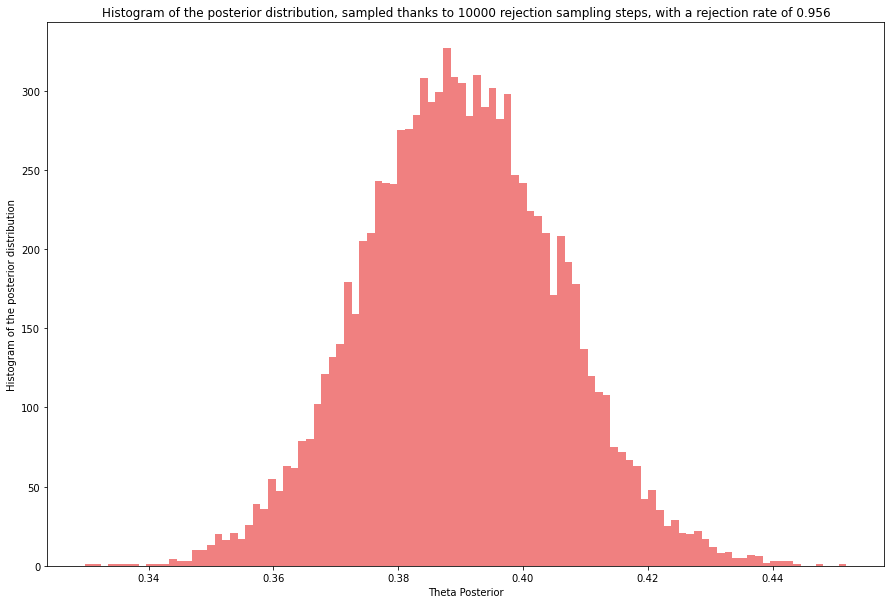

In [11]:
fig, ax = plt.subplots(1, figsize =(15, 10))
ax.hist(posterior_samples, bins=100, color='lightcoral')
plt.title('Histogram of the posterior distribution, sampled thanks to 10000 rejection sampling steps, with a rejection rate of ' + str(1-np.round(acceptance_rate, 3)))
ax.set_xlabel('Theta Posterior')
ax.set_ylabel('Histogram of the posterior distribution')
plt.show(fig)

#### Numerical Summaries of the distribution

In [12]:
import scipy

mean = np.mean(posterior_samples)
std = np.std(posterior_samples)
percentiles = np.percentile(posterior_samples, [2.5, 97.5])
mode = scipy.stats.mode(np.round(posterior_samples, 4))

print('Theta MLE is:', MLE, '\n-----------------------------------')
print('The posterior mean is ', mean)
print('The posterior Standard Deviation is ', std)
print('The posterior 95% percentiles are ', percentiles)
print('The Mode of the posterior Distribution is ', mode[0])

Theta MLE is: 0.38986556359875907 
-----------------------------------
The posterior mean is  0.390030758141894
The posterior Standard Deviation is  0.015580024262046861
The posterior 95% percentiles are  [0.35969095 0.42098157]
The Mode of the posterior Distribution is  [0.3843]


We can see that it is easy to summary the posterior distribution with numerical quantities. The only 'open-ended' question is how to numerically the mode of a distribution:
- We could visually determine it
- Compute it, and therefore locate the biggest mode in the posterior distribution

**INTERPRETATION:**

We have found samples for the posterior distribution that allowed us to create a histogram of it. Furthermore, we have computed 95% **credible** intervals for the parameter $\theta$. 
Several things need to be pointed out:
- The **rejection rate** of the rejection sampling procedure is very high, we used it to define the CI. This should point out to the fact that the likelihood is not quite constant accross the entire domain [0; 1]. Let us check this by studying **Variations of the likelihood**.
    Since the likelihood is strictly concave, the derivative is non-increasing, meaning that it is initially positive then negative. This means that the original function is increasing and then decreasing. Therefore, the maximum variation is obtained when computing $\max\left(\mathcal{L}(\theta^{MLE})-\mathcal{L}(0)~,~ \mathcal{L}(\theta^{MLE})-\mathcal{L}(1)\right)$. We realise that this value is high, which explains the high variation in the likelihood function, which explains why the acceptance rate is that low

- The **shape** of the posterior: We realize that the posterior is unimodal. Something that is interesting is that the posterior seems like a Gaussian posterior. It seems like it is centered around $k*\theta^{MLE} + (1-k)*0.5$ of the likelihood. This is reasonable, we expected the prior to have an influence on the posterior and we can see that the posterior mean is centered around $\theta_{post}$, which seems to be between the prior mean and the likelihood mean. We expect this posterior to get closer to $\theta^{MLE}$ as the number of data points increase.

- Credible Intervals for the posterior: we can se that the credible intervals are quite narrow, meaning that we do have much information in our posterior (we knew that $\theta$ was in [0; 1], now we can affirm with 95% certainty that it is in [0.3599; 0.4209], and all the values in this interval seem **fairly distributed**. Epistemic uncertainty is not high in this experiment.


<a id="sA3"></a>
<div class='exercise-r'>  

**[A3](#qA3)**

</div>

Carry out the weighted bootstrap to simulate 1,000 values of $\theta$ from the posterior distribution.  In doing so, simulate 10,000 values from the prior distribution to use as the discrete distribution from which the posterior draws will be simulated via the importance weights.  As above, plot a histogram of these values, and provide numerical summaries of the distribution of 1,000 values.  Interpret the results, and compare to the results of rejection sampling.

In [13]:
# your code here
thetas_sampled = []

#We simulate 10000 values from the prior
while len(thetas_sampled) < N:
    theta_sampled = sampling_prior()
    if theta_sampled is not None:
        thetas_sampled.append(theta_sampled)
thetas_sampled = np.array(thetas_sampled).reshape(N,)

#We use the importance weights, normalizing the values 
importance_weight = bernoulli_likelihood(thetas_sampled, y)
q = importance_weight/np.sum(importance_weight)
theta_IS = np.random.choice(a=thetas_sampled, p=q, size=1000)

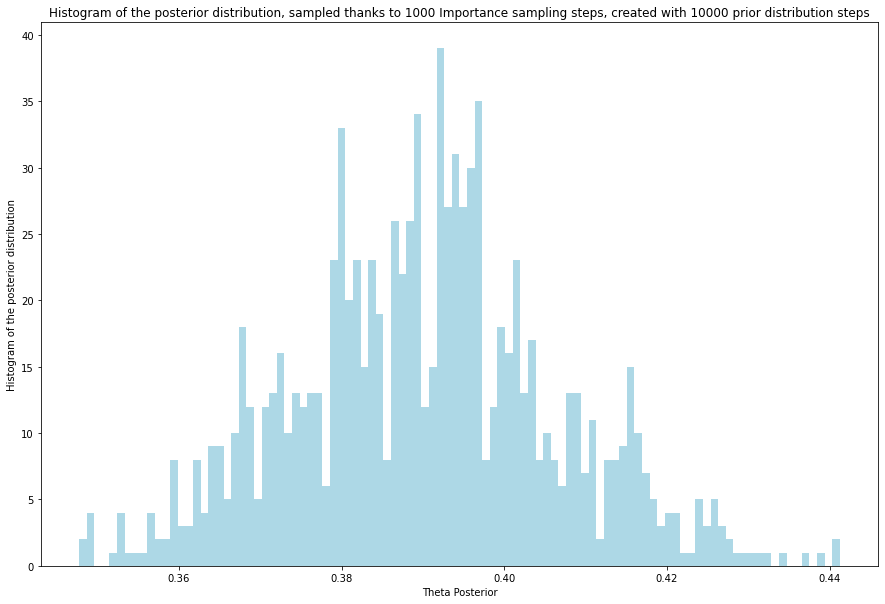

In [14]:
fig, ax = plt.subplots(1, figsize =(15, 10))
ax.hist(theta_IS, color='lightblue', bins=100)
plt.title('Histogram of the posterior distribution, sampled thanks to 1000 Importance sampling steps, created with 10000 prior distribution steps')
ax.set_xlabel('Theta Posterior')
ax.set_ylabel('Histogram of the posterior distribution')
plt.show(fig)

In [15]:
mean = np.mean(theta_IS)
percentiles = np.percentile(theta_IS, [2.5, 97.5])
mode = scipy.stats.mode(np.round(theta_IS, 4))

print('Theta MLE is:', MLE, '\n-----------------------------------')
print('The posterior mean is ', mean)
print('The posterior 95% percentiles are ', percentiles)
print('The Mode of the posterior Distribution is ', mode[0])

Theta MLE is: 0.38986556359875907 
-----------------------------------
The posterior mean is  0.39010355981481687
The posterior 95% percentiles are  [0.35953563 0.42406569]
The Mode of the posterior Distribution is  [0.3925]


**INTERPRETATION:**

We can see that both the shape of the posterior distribution and the numerical summary of the posterior are **very consistent** with our rejection sampling method. The posterior is centered around the mean, and resembles a Gaussian distribution, similarly to the rejection sampling method; we can however see that it is not unimodal unlike the posterior yielded by the former method (this is certainly due to the fact that we have nto sampled enough observations). 

However, there is one question that one might want to ask: how is it that we get *very similar* credible intervals whereas in this case we samples 10 times less samples than during rejection sampling ? This is due to the fact that we are **not in the frequentist case**: credible intervals are not expected to shrink with the number of observations. 

One key result in both our approaches is that both Credible Intervals for the mean are very similar, allowing us to think that our procedures have converged. 

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part B: Bayesian Logistic Regression and Varying-Intercepts Model

[Return to contents](#contents)



<a id="part2intro"></a>

## Overview 

[Return to contents](#contents)

The second model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part2questions"></a>

### <div class='exercise'>Part B: Questions</div> 

[Return to contents](#contents)


<a id="qB1"></a>

**[B1](#sB1)** 

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

<a id="qB2"></a>

**[B2](#sB2)**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

<a id="qB3"></a>

**[B3](#sB3)**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

<a id="qB4"></a>

**[B4](#sB4)** 

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

<a id="qB5"></a>

**[B5](#sB5)**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

<a id="qB6"></a>

**[B6](#sB6)**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

<a id="qB7"></a>

**[B7](#sB7)** 

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

<a id="qB8"></a>

**[B8](#sB8)**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

<a id="qB9"></a>

**[B9](#sB9)**

What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts?

<a id="part2solutions"></a>

## Part B: Solutions

[Return to contents](#contents)

<a id="sB1"></a>
<div class='exercise-r'>  

**[B1](#qB1)**
    
</div>

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [16]:
# your code here
data.loc[data['district']==61, 'district'] = 54
data.loc[data['district']==60, 'district'] = 0

<a id="sB2"></a>
<div class='exercise-r'>  

**[B2](#qB2)**
    
</div>

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

##### Generative Model

In [17]:
intercepts = []
for index in range(60):
    intercept_district_j = np.random.normal(2, 1)
    intercepts.append(intercept_district_j)
intercept = np.array(intercepts)
logits = intercept[data.district] + 4*data['urban'] - 3*data['living.children'] -2*data['age_mean']
probabilities = 1/(1 + np.exp(-logits))
U = np.random.uniform(size=probabilities.shape[0])
bernoulli_variables = probabilities > U
print('The average of subjects using contraceptives is ' + str(np.mean(bernoulli_variables)))

The average of subjects using contraceptives is 0.4725956566701138


The overall average sits at $47.1\% \in [0.46,0.48]$

<a id="sB3"></a>
<div class='exercise-r'>  

**[B3](#qB3)**
    
</div>

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

We are going to fit the varying-intercept model using the $\tau$ parameter from pm.Normal. This will allow us to sample the variance from a Gamma distribution, which is easier than leveraging Inverse gammas. We sample 13000 steps of the chain, from which we burn the first 8000, in order to get better results.

In [18]:
# your code here
with pm.Model() as district_model:
    mu0 = pm.Normal('Prior_Mean', mu=0, sigma=100)
    sigma0 = pm.Gamma('Prior_Variance', alpha=0.1, beta=0.1)
    beta_0 = pm.Normal('Intercept', mu=mu0, tau=sigma0, shape=60)
    intercepts = beta_0[data.district]
    beta_1 = pm.Normal('Urban_coef', mu=0, sigma=100)
    beta_2 = pm.Normal('Children_coef', mu=0, sigma=100)
    beta_3 = pm.Normal('Age_coef', mu=0, sigma=100)
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(intercepts + beta_1*data.urban + beta_2*data['living.children'] + beta_3*data.age_mean))
    contraceptive_use = pm.Bernoulli('Contraceptive Use', p=p_i, observed=bernoulli_variables)
    trace = pm.sample(5000, tune=8000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Age_coef, Children_coef, Urban_coef, Intercept, Prior_Variance, Prior_Mean]
Sampling 4 chains, 285 divergences:  78%|███████▊  | 40561/52000 [27:59<07:53, 24.16draws/s]  
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7138038813445673, but should be close to 0.9. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<a id="sB4"></a>
<div class='exercise-r'>  

**[B4](#qB4)**
    
</div>

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

In [19]:
variables = {'Prior_Mean':2, 'Prior_Variance':1, 'Urban_coef':4, 'Children_coef':-3, 'Age_coef':-2}

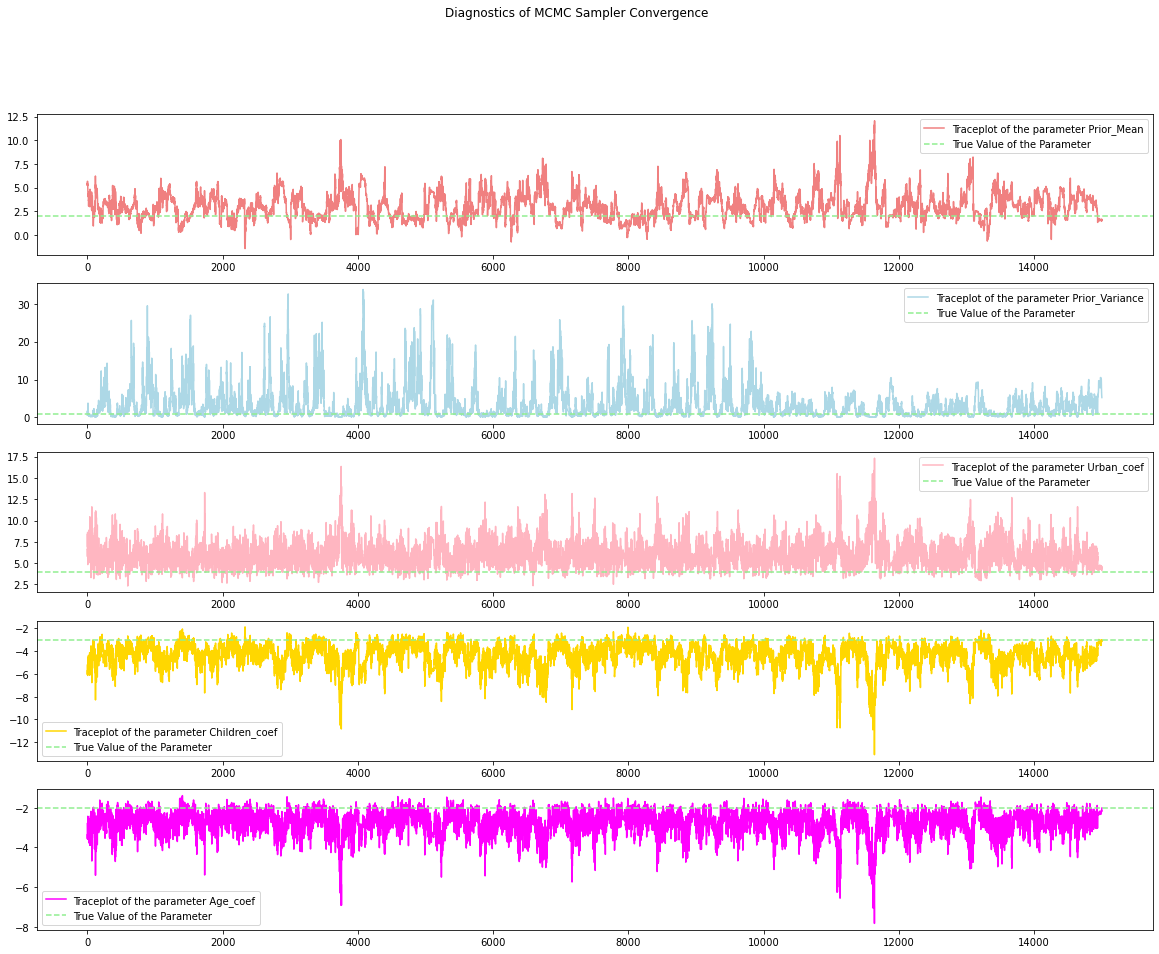

In [20]:
# your code here
fig, ax = plt.subplots(5, figsize = (20, 15))
plt.suptitle('Diagnostics of MCMC Sampler Convergence')
colors=['lightcoral', 'lightblue', 'lightpink', 'gold', 'magenta']
for i, variable in enumerate(variables.keys()):
    ax[i].plot(trace[variable], color=colors[i], label='Traceplot of the parameter ' + variable)
    ax[i].axhline(y=variables.get(variable), color='lightgreen', linestyle='--', label='True Value of the Parameter')
    ax[i].legend()
plt.show(fig)
    

In [ ]:
pm.traceplot(trace)
plt.show()

In [ ]:
df = pm.summary(trace)
df.loc[variables, ]

**INTERPRETATION:**

According to the $\hat{R}$ statistics, we can see that every one of the different MCMC samplings for the parameters are expected to have reasonably converged. Moreover, we can see from the traceplots that the samples appear to have mixed, they seem like an uncorrelated random walk meaning that we expect the sampler to have attained a zone with high density mass. 

Furthermore, we can see that the different samplings have converged to a distribution where the credible intervals **contain** the true values, and where the true values are quite central to the distribution (based on the 94% *credible* intervals). This indicates that, although the posterior mean is not right on the true parameter used to create the synthetic data, it captures efficiently its true value.

**Conclusion**: it looks like the sampler has converged.

<a id="sB5"></a>
<div class='exercise-r'>  

**[B5](#qB5)**
    
</div>

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

In [ ]:
indexes = [9, 19, 29, 39, 49, 59]
interesting_parameters = trace['Intercept'][:, np.array(indexes)].T

In [ ]:
fig, ax = plt.subplots(6, figsize=(20, 15))
plt.suptitle('Histograms of the posterior distributions')
colors=['lightcoral', 'lightblue', 'lightpink', 'gold', 'magenta', 'green']
for i, interesting_posterior in enumerate(interesting_parameters):
    ax[i].hist(interesting_posterior, bins=100, color=colors[i], label='Posterior Distribution')
    ax[i].axvline(intercept[indexes[i]], linestyle='--', color='lightgreen', label='True Parameter')
    ax[i].legend()

**INTERPRETATION:**

We can see that the true parameters used to generate this synthetic data are being contained within the posterior distribution of the parameter samples by the NUTS MCMC sampler. There are not specifically central to the posterior distribution but are contained within the principal mode of the unimodal posterior distribution, which seems reasonable. 

Therefore, our point of checking whether one could reconstruct true parameters from MCMC sampling is verified thanks to this little experiment, we could therefore fit the varying-intercept model to the true data and expect to recover a reasonable approximation of the true parameters that generated this simulated data.

<a id="sB6"></a>
<div class='exercise-r'>  

**[B6](#qB6)**
    
</div>

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [ ]:
# your code here
with pm.Model() as varying_intercept_model:
    mu0 = pm.Normal('Prior_Mean', mu=0, sigma=100)
    # sigma0 = pm.InverseGamma('Prior_Variance', alpha=0.1, beta=10)  # in pymc3, beta is the scale not the rate
    sigma0 = pm.Gamma('Prior_Variance', alpha=0.1, beta=0.1)
    beta_0 = pm.Normal('Intercept', mu=mu0, tau=sigma0, shape=60)
    # beta_0 = pm.Normal('Intercept', mu=mu0, sigma=1/sigma0, shape=60)
    intercepts = beta_0[data.district]
    beta_1 = pm.Normal('Urban_coef', mu=0, sigma=100)
    beta_2 = pm.Normal('Children_coef', mu=0, sigma=100)
    beta_3 = pm.Normal('Age_coef', mu=0, sigma=100)
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(intercepts + beta_1*data.urban + beta_2*data['living.children'] + beta_3*data.age_mean))
    contraceptive_use = pm.Bernoulli('Contraceptive Use', p=p_i, observed=y)
    trace = pm.sample(5000, tune=8000, target_accept=0.9)

<a id="sB7"></a>
<div class='exercise-r'>  

**[B7](#qB7)**
    
</div>

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

In [ ]:
df = pm.summary(trace)
df.loc[variables, ]

In [ ]:
# your code here
fig, ax = plt.subplots(2,5, figsize = (40, 10))
plt.suptitle('Diagnostics of MCMC Sampler Convergence')
colors=['lightcoral', 'lightblue', 'lightpink', 'gold', 'magenta']
for i, variable in enumerate(variables.keys()):
    ax[0][i].plot(trace[variable], color=colors[i], label='Traceplot of the parameter ' + variable)
    ax[1][i].hist(trace[variable], bins=30, color=colors[i], label='Histogram of the parameter ' + variable)
    ax[0][i].legend()
    ax[1][i].legend()

plt.show(fig)

In [ ]:
pm.traceplot(trace)
plt.show()

**INTERPRETATION:**

- Information from the traceplots: The sampler has converged since the posterior distributions has mixed. The sampler has reached a zone of high density mass. 
- Information from the $\hat{R}$: the different chains sampled from different initialization points have similar statistics, meaning that from a certain point on, they have roughly converged to the same zone (thus exhibiting similar mean and variance). 
- Information from the 94% credible intervals: we can see that the intervals are quite narrow, meaning that there is little uncertainty in the posterior estimation atthe end of the sampling procedure

<a id="sB8"></a>
<div class='exercise-r'>  

**[B8](#qB8)**
    
</div>

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

Let us recall from the formula that:

$$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$$

and then the contracteptive use $Y_{ij} \sim Ber(p_{ij})$

Therefore, the only coefficient varying between the different counties (when considering the **posterior means**) is the intercept. 

Last, we have $p_{ij} = Sigm(\beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean})$. Since $Sigmoid$ is an increasing function, we are looking for the biggest posterior mean accross the different intercepts.

In [ ]:
# your code here
intercepts_mean = df.iloc[1:61, :]['mean'].sort_values(ascending=False)
highest_contraceptive = intercepts_mean.head(1)
lowest_contraceptive = intercepts_mean.tail(1)
print('Highest rate of contraceptive: ',  highest_contraceptive)
print('Lowest rate of contraceptive: ', lowest_contraceptive)

**INTERPRETATION:**

Based on the posterior means and independent of other factors, the district with the highest rate of contraceptive is district 56 and the district with the lowest rate of contraceptive is district 11.

<a id="sB9"></a>
<div class='exercise-r'>  

**[B9](#qB9)**
    
</div>

What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts?

$\mathbb{E}[\mu_0| Y] = -1.597 $  with Credible interval $[-2.077; -1.104]$

$\mathbb{E}[\tau_0| Y] = 3.914 $  with Credible interval $[1.391; 7.095]$
Therefore, $\mathbb{E}[\sigma_0| Y] = \sqrt(\frac{1}{3.914}) $  with Credible interval $[\sqrt(\frac{1}{7.095}); \sqrt(\frac{1}{1.391})]$

$\mathbb{E}[\sigma_0| Y] = 0.505 $  with Credible interval $[0.375;  0.847]$

**INTERPRETATION:**

From the 94% credible interval of the posterior on $\sigma_0$, one can assume that the distribution of $\sigma_0$ is significalty far away from 0. Therefore, since in the varying intercept model, intercepts are drawn from $\mathcal{N}(\mu_0, \sigma_0)$, we can assume that these values will be significantly different between the different counties. 
The difference between the varying intercept model, compared to a model with a single intercept value for all districts is that a model with a single intercept value would be $\sigma_0 = 0$. Here, since the information brought on by the posterior $\sigma_0$ says that the likelihood of the data has brought on $\sigma_0$ to differ significantly from 0: this is the advantage of the Bayesian approach, we have let data speak for itself. 

Therefore, $\sigma_0$ provide evidence in support of the varying-intercept model.

However, for $\mu_0$, we are not conviced that the posterior mean brings **any** information in support of the varying-intercept model. Indeed:
- if the posterior distribution is centered at $\mu_0=4$, but the posterior variance is really close to 0 $\sigma_0 \approx 0$ then this would be evidence against the varying-intercept model. The same thing would happen for any value of $\mu_0$

Therefore, we think that evidence can be read off the posterior value of $\sigma_0$, and in that case it provides evidence in support of the varying-intercept model

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part C: Varying-Coefficients Model and Model Selection

[Return to contents](#contents)


<a id="part3intro"></a>

## Overview 

[Return to contents](#contents)

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:** Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<a id="part3questions"></a>

### <div class='exercise'>Part C: Questions</div> 

[Return to contents](#contents)

<a id="qC1"></a>

**[C1](#sC1)** 

Fit the varying-coefficients model described above to the real training data.

<a id="qC2"></a>

**[C2](#sC2)** 

Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the prior varying-intercepts model. What do you observe?

<a id="qC3"></a>

**[C3](#sC3)** 

Plot the distributions of posterior means and credible intervals for each predictor's coefficient by district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

<a id="qC4"></a>

**[C4](#sC4)** 

Use all of the information you've gleaned thus far to build Bayesian logistic regression classifiers for both your varying-intercepts model (from B7) and your varying-coefficients model (from C1). Then, use each model to make predictions on your training and test sets.

  - Report each model's classification percentages and accuracy scores on both the training and test sets, as well as the trivial accuracy scores you would achieve with a "naive" model that predicts only the most frequent outcome observed in your training data.
  
  
  - What do you observe from these results?
  
  
  - Which model appears to be the best (i.e. varying-intercept or varying-coefficient), and what is your rationale?

<a id="part3solutions"></a>

## Part C: Solutions

[Return to contents](#contents)

<a id="sC1"></a>
<div class='exercise-r'>  

**[C1](#qC1)**
    
</div>

Fit the varying-coefficients model described above to the real training data.

In [ ]:
# your code here
with pm.Model() as varying_coefficients_model:
    mu0 = pm.Normal('Prior_Mean', mu=0, sigma=100)
    sigma0 = pm.Gamma('Prior_Variance_0', alpha=0.1, beta=0.1)
    beta_0 = pm.Normal('Intercept', mu=mu0, tau=sigma0, shape=60)
    intercepts = beta_0[data.district]
    sigma1 = pm.Gamma('Prior_Variance_1', alpha=0.1, beta=0.1)
    beta_1 = pm.Normal('Urban_coef', mu=0, tau=sigma1, shape=60)
    beta1 = beta_1[data.district]
    sigma2 = pm.Gamma('Prior_Variance_2', alpha=0.1, beta=0.1)
    beta_2 = pm.Normal('Children_coef', mu=0, tau=sigma2, shape=60)
    beta2 = beta_2[data.district]
    sigma3 = pm.Gamma('Prior_Variance_3', alpha=0.1, beta=0.1)
    beta_3 = pm.Normal('Age_coef', mu=0, sigma=sigma3, shape=60)
    beta3 = beta_3[data.district]
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(intercepts + beta1*data.urban + beta2*data['living.children'] + beta3*data.age_mean))
    contraceptive_use = pm.Bernoulli('Contraceptive Use', p=p_i, observed=y)
    trace_vc = pm.sample(5000, tune=7000, target_accept=0.9)

<a id="sC2"></a>
<div class='exercise-r'>  

**[C2](#qC2)**
    
</div>

Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the prior varying-intercepts model. What do you observe?

#### R-hats

In [ ]:
# your code here
df = pm.summary(trace_vc)

In [ ]:
df['r_hat'].value_counts()

From the distribution of R plots, we can consider that the model has globally converged, since it is understandable that models with more parameters are less straightforward to converge. 

#### TracePlots

Let us visualize some traceplots for observing the distribution of the model parameters. We are going to draw a random district and check the traceplots of the parameters for this district.

In [ ]:
district = np.random.randint(0, 59)

In [ ]:
variables = ['Intercept', 'Urban_coef', 'Children_coef', 'Age_coef']
fig, ax = plt.subplots(4, figsize = (20, 15))
plt.suptitle('Diagnostics of MCMC Sampler Convergence for the Varying-Coefficient Model for district ' + str(district))
colors=['lightcoral', 'lightblue', 'lightpink', 'gold']
for i, variable in enumerate(variables):
    ax[i].plot(trace_vc[variable][:, district], color=colors[i], label='Traceplot of the parameter ' + variable)
    ax[i].legend()
plt.show(fig)

In [ ]:
pm.traceplot(trace_vc)
plt.show()

From the traceplots, we can observe that the different samples appear to have converged, since the different states of the chain seem very much uncorrelated between each others. 

**INTERPRETATION:**

From the $\hat{R}$ values and the traceplots of the different parameters for one district, it appears that the varying-intercept model seems to have converged. 

<a id="sC3"></a>
<div class='exercise-r'>  

**[C3](#qC3)**
    
</div>

Plot the distributions of posterior means and credible intervals for each predictor's coefficient by district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

In [ ]:
# your code here
az.plot_forest(kind='forestplot', data=trace_vc['Intercept'].T)
ax[0].set_title('Credible Intervals for the different intercepts')

In [ ]:
az.plot_forest(kind='forestplot', data=trace_vc['Urban_coef'].T)
ax[0].set_title('Credible Intervals for the different Urban Coefficients')

In [ ]:
az.plot_forest(kind='forestplot', data=trace_vc['Children_coef'].T)
ax[0].set_title('Credible Intervals for the different children coefficients')

In [ ]:
az.plot_forest(kind='forestplot', data=trace_vc['Age_coef'].T)
ax[0].set_title('Credible Intervals for the different Age coefficients')

**INTERPRETATION:**

The things we observe for the different posteriors credible intervals are:
- For the Age coefficients, we can see that the different posteriors are **very** similar accross the 60 different districts, whether it is in terms of posterior mean or 94% Credible Interval. Therefore, this leads us to thinking that sing varying coefficients for this feature is maybe not useful, and that the posterior seems like all of the different coefficients have been drawn from the same distribution
- For the children, urban and intercept coefficient, the conclusion is less obvious. We can see that the credible intervals are quite overlapping amongst the different posteriors for different districts. But solely based on these plots, it is maybe not cautious to conclude that we might not need any varying coefficients on this model. Indeed, we **know** that the varying intercept model is relevant from the posterior distribution of the variance of the intercept-generating distribution. If one conludes based on this visualization that none of the varying coefficient is relevant, then we end up saying the varying-intercept model is not relevant, which would be wrong.

Therefore, we might assume that for the Age feeature, we don't need any varying coefficient, but more careful analysis should be conducted for assuming the same things for other features (like analyzing independent varying models for every feature).

<a id="sC4"></a>
<div class='exercise-r'>  

**[C4](#qC4)**
    
</div>

Use all of the information you've gleaned thus far to build Bayesian logistic regression classifiers for both your varying-intercepts model (from B7) and your varying-coefficients model (from C1). Then, use each model to make predictions on your training and test sets.

  - Report each model's classification percentages (i.e. percentage of class `1` predictions) and accuracy scores on both the training and test sets, as well as the trivial accuracy scores you would achieve with a "naive" model that predicts only the most frequent outcome observed in your training data.
  
  
  - What do you observe from these results?
  
  
  - Which model appears to be the best (i.e. varying-intercept or varying-coefficient), and what is your rationale?

In [ ]:
ok

In [ ]:
# your code here
data_train,data_test = pd.read_csv('data/dataset_2_train.csv'),pd.read_csv('data/dataset_2_test.csv')
y_train,y_test = data_train.contraceptive_use,data_test.contraceptive_use
data_train.loc[data_train['district']==61, 'district'] = 54
data_train.loc[data_train['district']==60, 'district'] = 0
data_test.loc[data_test['district']==61, 'district'] = 54
data_test.loc[data_test['district']==60, 'district'] = 0
data_train

### Varying intercept models

In [ ]:
with pm.Model() as varying_intercept_model_train:
    mu0 = pm.Normal('Prior_Mean', mu=0, sigma=100)
    # sigma0 = pm.InverseGamma('Prior_Variance', alpha=0.1, beta=10)  # in pymc3, beta is the scale not the rate
    sigma0 = pm.Gamma('Prior_Variance', alpha=0.1, beta=0.1)
    beta_0 = pm.Normal('Intercept', mu=mu0, tau=sigma0, shape=60)
    # beta_0 = pm.Normal('Intercept', mu=mu0, sigma=1/sigma0, shape=60)
    intercepts = beta_0[data.district]
    beta_1 = pm.Normal('Urban_coef', mu=0, sigma=100)
    beta_2 = pm.Normal('Children_coef', mu=0, sigma=100)
    beta_3 = pm.Normal('Age_coef', mu=0, sigma=100)
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(intercepts + beta_1*data_train.urban + beta_2*data_train['living.children'] + beta_3*data_train.age_mean))
    contraceptive_use = pm.Bernoulli('Contraceptive Use', p=p_i, observed=y_train)
    trace_i_train = pm.sample(5000, tune=7000, target_accept=0.9)


In [ ]:
#The following vectors contains 500 predictions for the class 1 
ppc_i_train = pm.sample_ppc(trace_i_train, model=varying_intercept_model_train, samples=500)

print('The accuracy of the predictions of the varying_intercept_model for the training data is'
      ,accuracy_score(data_train['contraceptive_use'], np.asarray(ppc_i_train['Contraceptive Use'])[np.random.randint(0, 500)]))
print('The classification percentage of the varying_intercept_model for the training data is'
      ,np.asarray(ppc_i_train['Contraceptive Use'])[np.random.randint(0, 500)].mean())

In [ ]:
with pm.Model() as varying_intercept_model_test:
    mu0 = pm.Normal('Prior_Mean', mu=0, sigma=100)
    # sigma0 = pm.InverseGamma('Prior_Variance', alpha=0.1, beta=10)  # in pymc3, beta is the scale not the rate
    sigma0 = pm.Gamma('Prior_Variance', alpha=0.1, beta=0.1)
    beta_0 = pm.Normal('Intercept', mu=mu0, tau=sigma0, shape=60)
    # beta_0 = pm.Normal('Intercept', mu=mu0, sigma=1/sigma0, shape=60)
    intercepts = beta_0[data.district]
    beta_1 = pm.Normal('Urban_coef', mu=0, sigma=100)
    beta_2 = pm.Normal('Children_coef', mu=0, sigma=100)
    beta_3 = pm.Normal('Age_coef', mu=0, sigma=100)
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(intercepts + beta_1*data_test.urban + beta_2*data_test['living.children'] + beta_3*data_test.age_mean))
    contraceptive_use = pm.Bernoulli('Contraceptive Use', p=p_i, observed=y_test)
    trace_i_test = pm.sample(5000, tune=7000, target_accept=0.9)

In [ ]:
#The following vectors contains 500 predictions for the class 1 
ppc_i_test = pm.sample_ppc(trace_i_test, model=varying_intercept_model_test, samples=500)

print('The accuracy of the predictions of the varying_intercept_model for the testing data is'
      ,accuracy_score(data_test['contraceptive_use'], np.asarray(ppc_i_test['Contraceptive Use'])[np.random.randint(0, 500)]))
print('The classification percentage of the varying_intercept_model for the testing data is'
      ,np.asarray(ppc_i_test['Contraceptive Use'])[np.random.randint(0, 500)].mean())

### Varying coefficients models

In [ ]:
with pm.Model() as varying_coefficients_model_train:
    mu0 = pm.Normal('Prior_Mean', mu=0, sigma=100)
    sigma0 = pm.Gamma('Prior_Variance_0', alpha=0.1, beta=0.1)
    beta_0 = pm.Normal('Intercept', mu=mu0, tau=sigma0, shape=60)
    intercepts = beta_0[data.district]
    sigma1 = pm.Gamma('Prior_Variance_1', alpha=0.1, beta=0.1)
    beta_1 = pm.Normal('Urban_coef', mu=0, tau=sigma1, shape=60)
    beta1 = beta_1[data.district]
    sigma2 = pm.Gamma('Prior_Variance_2', alpha=0.1, beta=0.1)
    beta_2 = pm.Normal('Children_coef', mu=0, tau=sigma2, shape=60)
    beta2 = beta_2[data.district]
    sigma3 = pm.Gamma('Prior_Variance_3', alpha=0.1, beta=0.1)
    beta_3 = pm.Normal('Age_coef', mu=0, sigma=sigma3, shape=60)
    beta3 = beta_3[data.district]
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(intercepts + beta1*data_train.urban + beta2*data_train['living.children'] + beta3*data_train.age_mean))
    contraceptive_use = pm.Bernoulli('Contraceptive Use', p=p_i, observed=y_train)
    trace_c_train = pm.sample(5000, tune=7000, target_accept=0.9)

In [ ]:
#The following vectors contains 500 predictions for the class 1 
ppc_c_train = pm.sample_ppc(trace_c_train, model=varying_coefficients_model_train, samples=500)

print('The accuracy of the predictions of the varying_coefficients_model for the training data is'
      ,accuracy_score(data_train['contraceptive_use'], np.asarray(ppc_c_train['Contraceptive Use'])[np.random.randint(0, 500)]))
print('The classification percentage of the varying_coefficients_model for the training data is'
      ,np.asarray(ppc_c_train['Contraceptive Use'])[np.random.randint(0, 500)].mean())

In [ ]:
with pm.Model() as varying_coefficients_model_test:
    mu0 = pm.Normal('Prior_Mean', mu=0, sigma=100)
    sigma0 = pm.Gamma('Prior_Variance_0', alpha=0.1, beta=0.1)
    beta_0 = pm.Normal('Intercept', mu=mu0, tau=sigma0, shape=60)
    intercepts = beta_0[data.district]
    sigma1 = pm.Gamma('Prior_Variance_1', alpha=0.1, beta=0.1)
    beta_1 = pm.Normal('Urban_coef', mu=0, tau=sigma1, shape=60)
    beta1 = beta_1[data.district]
    sigma2 = pm.Gamma('Prior_Variance_2', alpha=0.1, beta=0.1)
    beta_2 = pm.Normal('Children_coef', mu=0, tau=sigma2, shape=60)
    beta2 = beta_2[data.district]
    sigma3 = pm.Gamma('Prior_Variance_3', alpha=0.1, beta=0.1)
    beta_3 = pm.Normal('Age_coef', mu=0, sigma=sigma3, shape=60)
    beta3 = beta_3[data.district]
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(intercepts + beta1*data_test.urban + beta2*data_test['living.children'] + beta3*data_test.age_mean))
    contraceptive_use = pm.Bernoulli('Contraceptive Use', p=p_i, observed=y_test)
    trace_c_test = pm.sample(5000, tune=7000, target_accept=0.9)

In [ ]:
#The following vectors contains 500 predictions for the class 1 
ppc_c_test = pm.sample_ppc(trace_c_test, model=varying_coefficients_model_test, samples=500)

print('The accuracy of the predictions of the varying_coefficients_model for the testing data is'
      ,accuracy_score(data_test['contraceptive_use'], np.asarray(ppc_c_test['Contraceptive Use'])[np.random.randint(0, 500)]))
print('The classification percentage of the varying_coefficients_model for the testing data is'
      ,np.asarray(ppc_c_test['Contraceptive Use'])[np.random.randint(0, 500)].mean())

In [ ]:
print('SUMMARY','\n--------------------------------------------------------')
print('The accuracy scores are:\n')

print('The accuracy of the predictions of the varying_intercept_model for the training data is'
      ,accuracy_score(data_train['contraceptive_use'], np.asarray(ppc_i_train['Contraceptive Use'])[np.random.randint(0, 500)]))
print('The accuracy of the predictions of the varying_intercept_model for the testing data is'
      ,accuracy_score(data_test['contraceptive_use'], np.asarray(ppc_i_test['Contraceptive Use'])[np.random.randint(0, 500)]))
print('The accuracy of the predictions of the varying_coefficients_model for the training data is'
      ,accuracy_score(data_train['contraceptive_use'], np.asarray(ppc_c_train['Contraceptive Use'])[np.random.randint(0, 500)]))
print('The accuracy of the predictions of the varying_coefficients_model for the testing data is'
      ,accuracy_score(data_test['contraceptive_use'], np.asarray(ppc_c_test['Contraceptive Use'])[np.random.randint(0, 500)]))

### Trivial model

We will fit a logistic model predicting for each row whether that person uses contraception; so it’s 0 or 1 based on whether the probability is greater than 0.5.

In [ ]:
data_train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train, 
                                                    data_train['contraceptive_use'], test_size=0.40, 
                                                    random_state=101)
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [ ]:
print(classification_report(y_test,predictions))

**INTERPRETATION:**

*Your answer here*


The model with the best accuracy is ______